In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

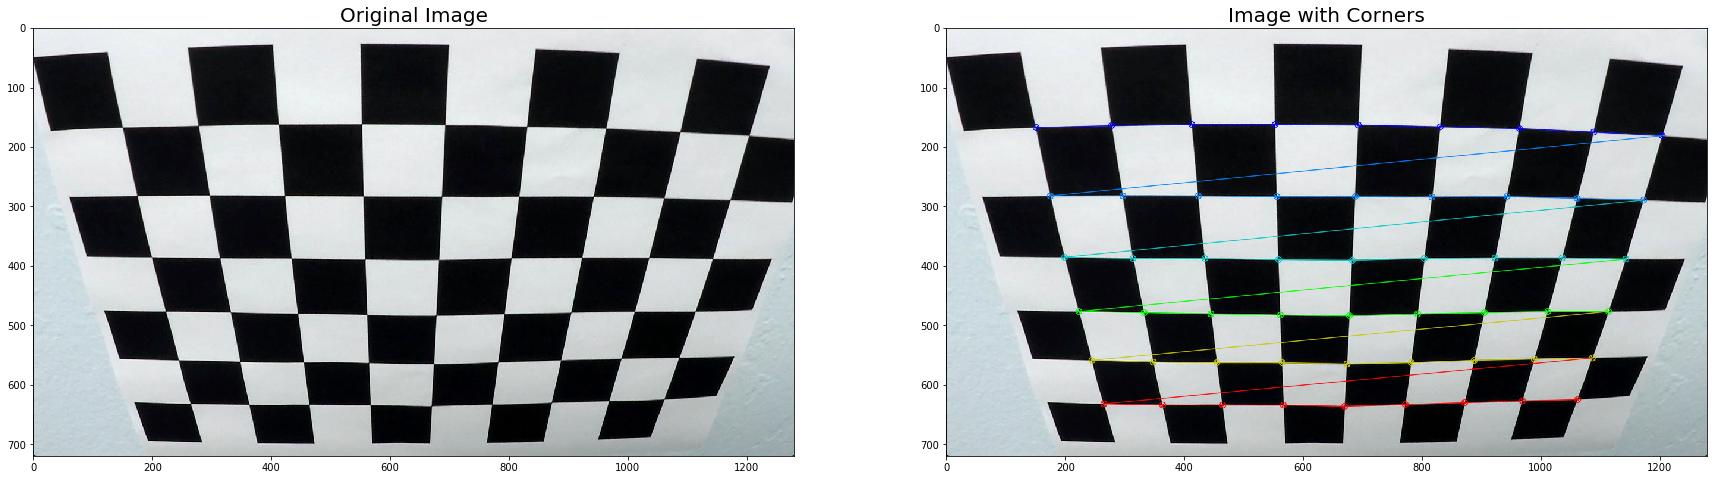

In [2]:
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints=[]
imgpoints=[] 
f, axes= plt.subplots(1,2,figsize=(30,30))
images = glob.glob('camera_cal/calibration*.jpg')



for index,image in enumerate(images):
    originalImage= cv2.imread(image)
    grayImg= cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY) 
    
    if(index==1 ):
        axes[0].set_title('Original Image', fontsize=20)
        axes[0].imshow(originalImage)
    ret, corners = cv2.findChessboardCorners(grayImg, (9,6), None)

    if(ret==True):
        objpoints.append(objp)
        imgpoints.append(corners)

        cv2.drawChessboardCorners(originalImage, (9,6), corners, ret)
        if(index==1):
            axes[1].set_title('Image with Corners', fontsize=20)
            axes[1].imshow(originalImage)


Text(0.5,1,'Undistorted')

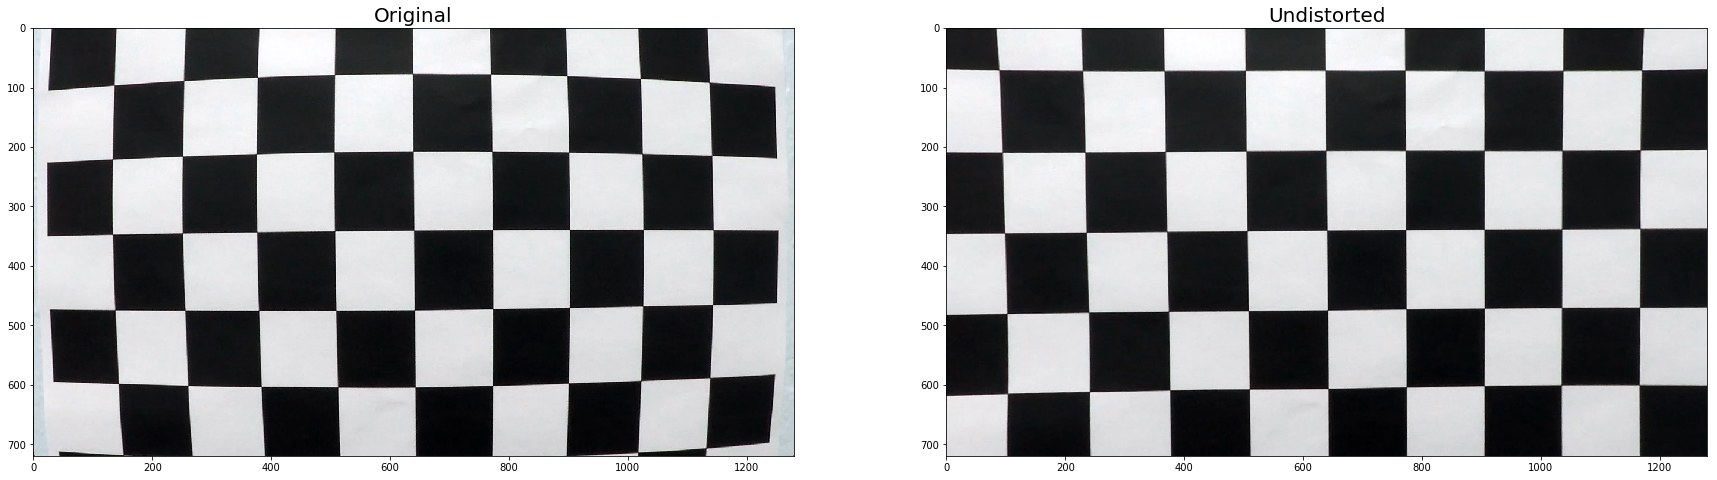

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

f, axes= plt.subplots(1,2,figsize=(30,30))

axes[0].imshow(img)
axes[0].set_title("Original", fontsize=20)
axes[1].imshow(dst)
axes[1].set_title("Undistorted", fontsize=20)


In [4]:

def undistortImage(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

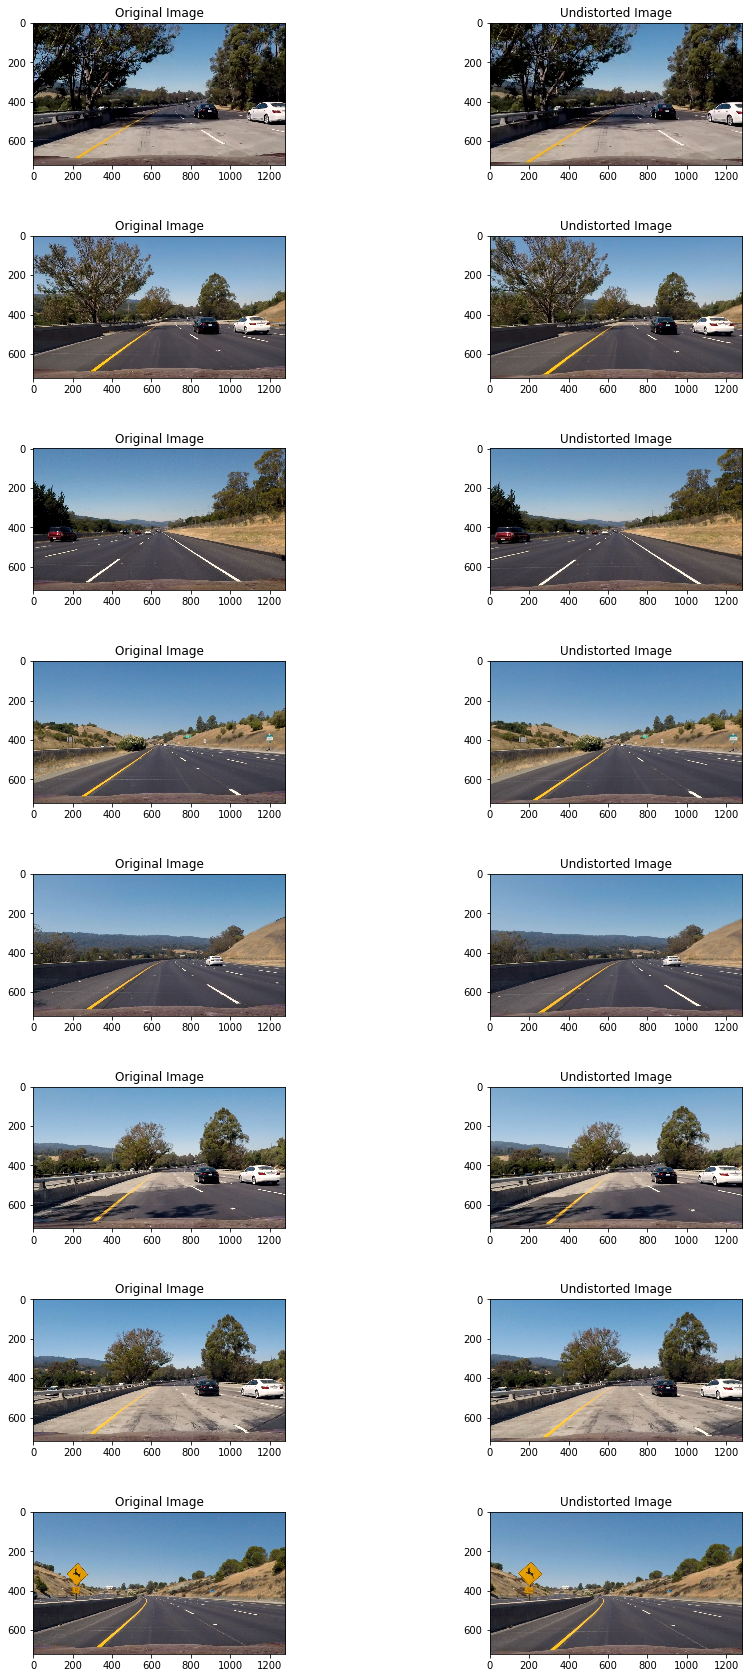

In [5]:

f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

images = glob.glob('test_images/*.jpg') 
original_untouched_images=[]

for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    original_untouched_images.append(originalImage)
    axes[index,0].imshow(originalImage)
    axes[index,0].set_title("Original Image")
    undistortedImg=undistortImage(originalImage)
    axes[index,1].set_title("Undistorted Image")
    axes[index,1].imshow(undistortedImg)

In [6]:
src=np.float32([[220,720],[1110, 720],[ 720,470],[570,470]]) 
dst= np.float32([[200 ,720], [1060  ,720], [1060 ,0], [200 ,0]])

def WarpPerspective(image):
    y=image.shape[0]
    x=image.shape[1]
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (x,y), flags=cv2.INTER_LINEAR)

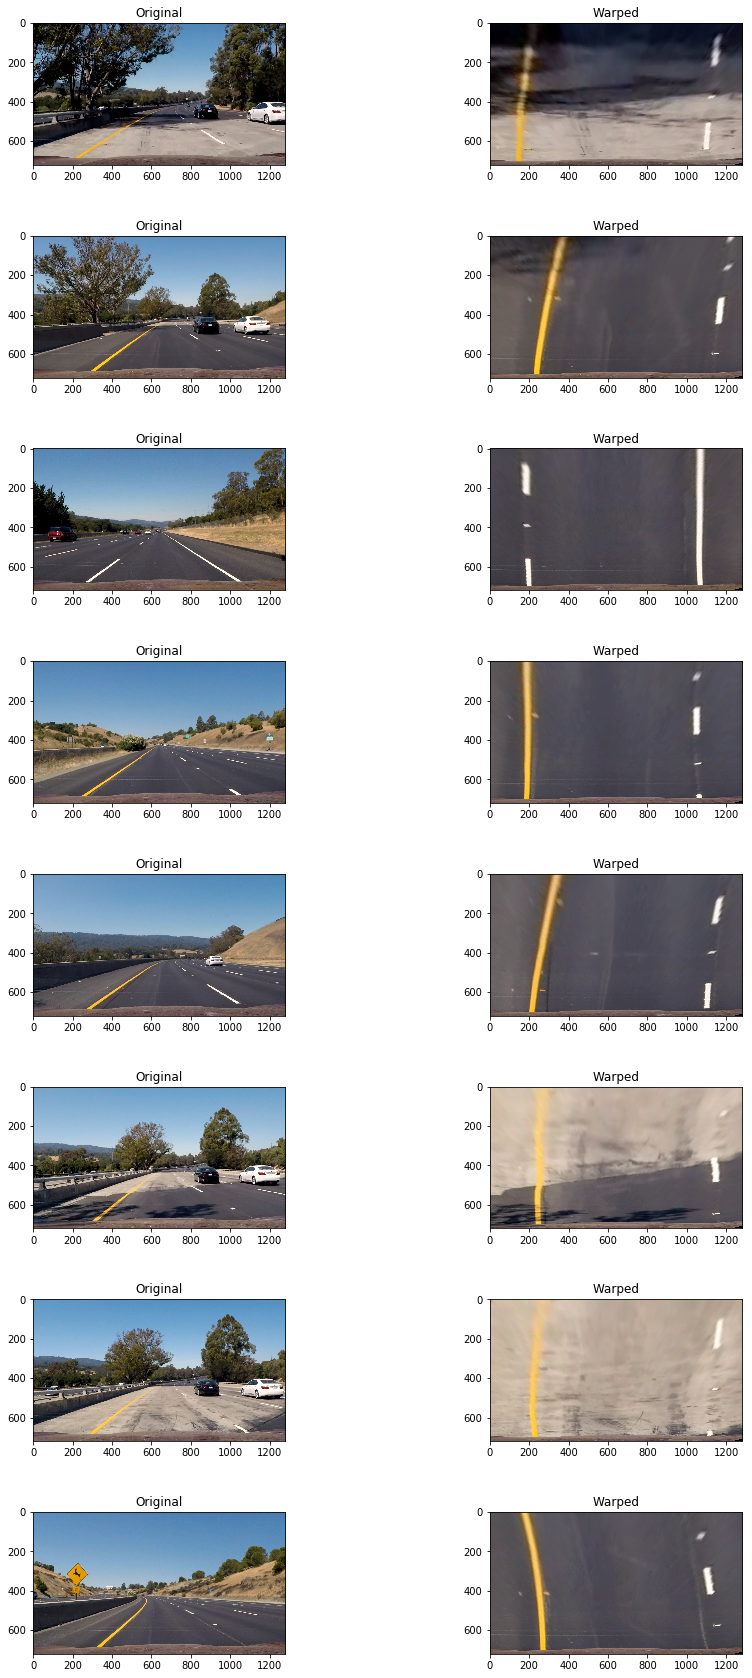

In [7]:
f, axes= plt.subplots(8,2,figsize=(15,30))
f.subplots_adjust(hspace=0.5)
warpedImages=[]
for index, image in enumerate(images):
    originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    untouchedImage= originalImage.copy()
    axes[index,0].imshow(originalImage)
    axes[index,0].set_title("Original")
    y=untouchedImage.shape[0]
    x=untouchedImage.shape[1]
    warped = WarpPerspective(untouchedImage)
    warpedImages.append(warped)
    axes[index,1].imshow(warped)
    axes[index,1].set_title("Warped")

In [89]:
def apply_thresholds(image, show=True):
    img= WarpPerspective(image)

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

   
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if show == True:
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistortImage(image),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary


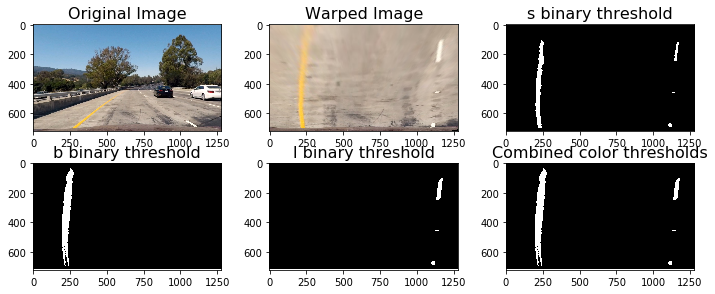

In [96]:
originalImager= cv2.imread("test_images/test1.jpg")
thresholded = apply_thresholds(originalImager)


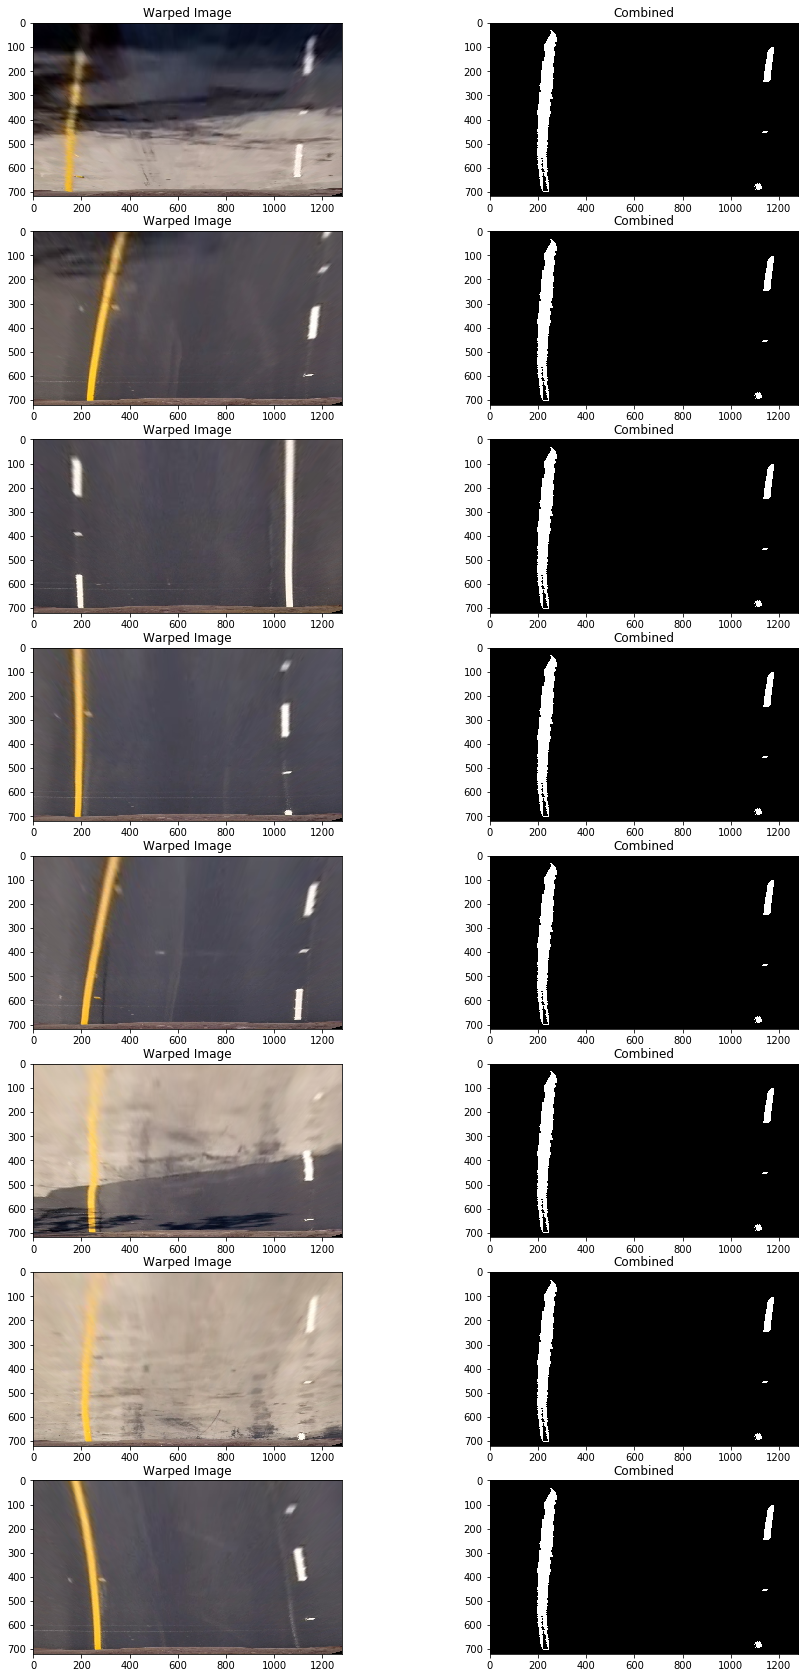

In [122]:
f, axes= plt.subplots(8,2,figsize=(15,30))
originalImager= cv2.imread("test_images/test1.jpg")

for index,warped in enumerate(warpedImages):
    combinedImage= apply_thresholds(originalImager, show=False)
    axes[index,0].imshow(warped)
    axes[index,0].set_title("Warped Image")
    axes[index,1].imshow(combinedImage,cmap='gray')
    axes[index,1].set_title("Combined")


In [19]:
def SlidingWindowSearch(binary_warped, plot=False):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
  
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 12
  
    window_height = np.int(binary_warped.shape[0]/nwindows)
  
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base
   
    width = 100
   
    minpix = 60
   
    left_lane_inds = []
    right_lane_inds = []

   
    for window in range(nwindows):
       
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - width
        win_xleft_high = leftx_current + width
        win_xright_low = rightx_current - width
        win_xright_high = rightx_current + width
        
        if(plot==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
       
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
     
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
      
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

In [140]:
originalImage = cv2.imread("test_images/test4.jpg")
binary = apply_thresholds(originalImage,show=False )

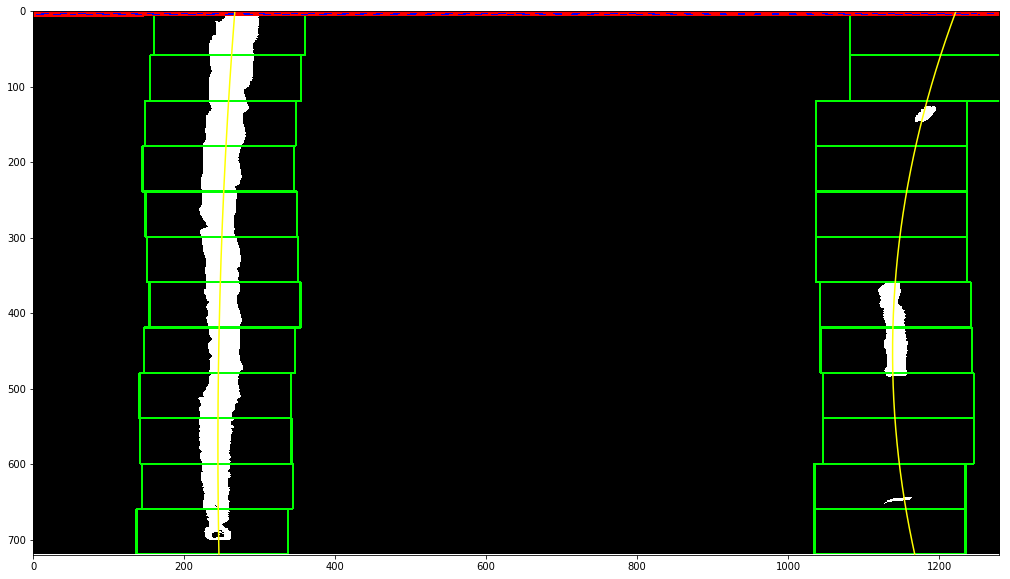

In [141]:
def VisualizeSlidingWindow(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.figure(figsize=(20,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

l,r,ld,rd,o=SlidingWindowSearch(binary, plot=True)
VisualizeSlidingWindow(warped,l,r,ld,rd,o)

In [142]:
def calc_values(img_shape, left_fit, right_fit):
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

    return left_fitx, right_fitx

In [143]:
def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)

    left_fitx, right_fitx = calc_values(binary_warped.shape, left_fit, right_fit)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, h-1, num=h)
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
 
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result


In [103]:
def CalculateDistance(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    positionCar= binary_warped.shape[1]/2
   
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval=np.max(ploty)
    
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    
    return distance

    
    
   

In [104]:
def measure_curvature(img_shape, fit):
    ym_per_pix = 30 / 720  
    xm_per_pix = 3.7 / 700  

    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

    fitx = fit[0] * ploty ** 2 + fit[1] * ploty + fit[2]

    y_eval = np.max(ploty)

    curve_fit = np.polyfit(ploty * ym_per_pix, fitx * xm_per_pix, 2)

    curvature = ((1 + (2 * curve_fit[0] * y_eval * ym_per_pix + curve_fit[1]) ** 2) ** 1.5) / np.absolute(2 * curve_fit[0])

    return curvature

In [130]:
import random
import datetime
import time

def pipeline(originalImage):
    undistort= undistortImage(originalImage)
    combinedImage= apply_thresholds(undistort, show=False)
    left_fit, right_fit,ld,rd, colored_lanes = SlidingWindowSearch(combinedImage)
    finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
    distance = CalculateDistance(combinedImage,left_fit,right_fit)
    l_radius_of_curvature = measure_curvature(combinedImage.shape, left_fit)
    r_radius_of_curvature = measure_curvature(combinedImage.shape, right_fit)
    curvature = l_radius_of_curvature + r_radius_of_curvature / 2
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(curvature))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(finalImage,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    newCombinedImage= np.dstack((combinedImage*255,combinedImage*255,combinedImage*255))
    return cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)   


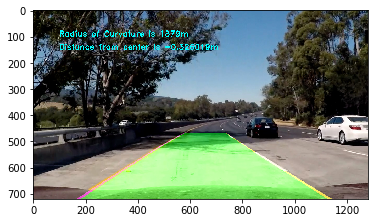

In [144]:
plt.imshow(pipeline(cv2.imread("test_images/test5.jpg")))
